In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('./src')

from Model import Model # Classe custom Modelo Deep
import pickle           # Pegar todos os dados dos digitos MNIST como binário pickle
from PIL import Image   # Manipulação de Pixels

# Lib para baixar Arquivos de Google Drive, gdown
!pip install gdown 




In [5]:
# Model 128x128 google drive id 17evOlNhhvR2pXszPVxTPcmj4UuVcTKqh
# MNIST_all_data.pickle LINK COMPLETO : https://drive.google.com/file/d/1ANAH0Esvr62yDX4uKJ6fnS9llWcmRRV2/view?usp=sharing

# Baixando Modelo salvo em binário com Pickle
!gdown https://drive.google.com/uc?id=17evOlNhhvR2pXszPVxTPcmj4UuVcTKqh --output ./models/Model_128x128.pickle
    
#!curl -L https://www.dropbox.com/s/gbcsb0ziszesjcd/Model_128x128.pickle?dl=1 --output ./models/Model_128x128.pickle

# Baixando Dicionário python com os 70 mil exemplos do MNIST
!gdown https://drive.google.com/uc?id=1ANAH0Esvr62yDX4uKJ6fnS9llWcmRRV2 --output ./assets/MNIST_all_data.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   144    0   144    0     0    144      0 --:--:-- --:--:-- --:--:--   177

100   320  100   320    0     0    320      0  0:00:01  0:00:01 --:--:--   320

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0  249M    0  183k    0     0  62586      0  1:09:45  0:00:03  1:09:42 99290
  1  249M    1 2567k    0     0   641k      0  0:06:38  0:00:04  0:06:34  855k
  3  249M    3  9.7M    0     0  2004k      0  0:02:07  0:00:05  0:02:02 2576k
  4  249M    4 11.1M    0     0  2273k      0  0:01:52  0:00:05  0:01:47 2745k
curl: (56) Failure when receiving data from the p

### Importando o Modelo da minha pasta de modelos treinados. 
#### Esse modelo vem um classe custom da class *Model*, o qual é utilizado apenas numpy na sua implementação
#### Tendo sideo treinado para reconhecer o digits do data set MNIST, com seguintes configurações:
#### - **2** hidden layers de **128** dimensões
#### - **0.035** learning rate
#### - **sigmoid** activation, em todas as camadas 
#### - **MSE** função custo
#### - **120** épocas, cada epoca passa por **40 mil** exemplos dos dados de treinamento

## Comentários sobre treinamento:
##### Houve experimentos anteriores, utilizando, duas (ou mais, porém esses demorariam muito na minha máquina) hidden layers de 64 dimensões, outra vez com 16 dimensões, e por fim 48.

Á priori, percebi com sigmoid 64 para 128 dimensões sempre achava um caminho que aprendia rápido o suficiente, com 50 épocas com lr = 0.035 
rapidamente chegava a 92% acurácia, e com mais algumas épocas chegava a 97% (*com dados de treinamento*). 

Porém eu temo que com tantas dimensões pode ocorrer de se especializar demais, eu penso nisso, porque mais lá pra baixo nesse notebook, existe uma sessão onde podemos assistir o que o modelo advinha com um exemplo *custom* de uma imagem 28x28 de um digito criada por mim no app **microsoft paint**, e nesse casos, com 128 dimensões, ele erra coisas que um modelo de 16 dimensões, não erraria, apesar do modelo de 16 ter uma acurácia menor (91%), me pareceu generalizar melhor. 
Eu imagino que com menos dimensões na camada escondida o Modelo é forçado a entender o que é mais importante, ao invez de "manter em mente" caracteristicas especificas dos dados de treinamento.

Além disso, os modelos com mais camadas de pequenas dimensões, demoraram  muito para aumentar acurácia, exemplo:
Modelo de:
	- 3 hidden layer de dimensões na sequencia (20,16,20)
	- **tangente hiperbolica**("tanh") activation, em todas as camadas
	- lr = 0.02
	- MSE, custo
	- 500 épocas de 40 mil exemplos
Esse modelo chegou a uma acurácia de 88%, muito inferior tanto em velocidade de treinamento, e acertos.
Mas, esse modelo de tanh, ele teve uma generalização decente, chegando a ser parecido com o Modelo que vamos usar (2 hidden de 128 dim).
Claro que foi só eu desenhando no paint e testando, mas te faz questionar um pouco se esse modelo continuasse treinando, ele teria uma generalização melhor?

In [4]:
# Modelo já Treinado, mencionado anteriormente
model = Model.load("./models/Model_128x128.pickle")

# traning_data, foi os 42 mil testados pelo modelo.
# dimensions, as dimensões usadas para treinamentodo modelo (784,128,128,10)
with open("./assets/MNIST_all_data.pickle", "rb") as file:
	all_data = pickle.load(file)
# Restante dos 28 mil exemplos que o modelo não viu, será nossos dados de teste
test_data_being_used = {
	"inputs" :	all_data["inputs" ][42000:],
	"outputs":	all_data["outputs"][42000:]
}

FileNotFoundError: [Errno 2] No such file or directory: './models/Model_128x128.pickle.pickle'

### Função usada para fazer predições do set MNIST com o Modelo. 
*Ao usar **test_prediction** ira mostrar a **imagem**, o **label** correto, e a **decisão** do modelo*

In [ ]:
def test_prediction(index, data, model:Model):
	current_image = data["inputs"][index]
	y_predict = model.predict(current_image)[0]
	prediction = (y_predict == y_predict.max()).astype(int)

	guess = list(prediction).index(1)
	
	label = data["outputs"][index]
	ground_truth = list(label).index(1)

	# Opção de desobrigar de fornecer label correto, para quando formor utilizar paint
	if len(label) < 10:
		label = "made on paint"
		ground_truth = " paint"

	print("Label: ", label)
	print("Prediction: ", prediction)

	plt.gray()
	plt.title("Model thinks it is: " + str(guess) + "\nGround truth: " + str(ground_truth))
	plt.imshow( current_image.reshape((28, 28)) * 255, interpolation='nearest')
	plt.xticks([])
	plt.yticks([0])
	plt.show()

## Função p/ testar a acurácia dos restante 28 mil digitos que o modelo não viu ainda
### e ainda retorna todos os indices errados

In [ ]:
def get_acurracy(testing_data):
	
	predicts = list()
	for y in testing_data["inputs"]:
		y_predict = model.predict(y)[0]
		prediction = (y_predict == y_predict.max()).astype(int)
		predicts.append(prediction)
	return model.accuracy(predictions=predicts, outputs=testing_data["outputs"], verbose=0)


## Array de indices onde o modelo errou
#### Acurácia: cerca de **98.9%** usando 28 mil exemplos dos dados de teste os quais o modelo nunca viu

In [ ]:
accuracy,wrong_indexes = get_acurracy(test_data_being_used)

print( "Qntd de exemplos:",len(test_data_being_used["inputs"]))
print(f"Indexes onde está errado: {wrong_indexes}\n")
print("Acurácia: ",accuracy,'\n' )

Qntd de exemplos: 28000
Indexes onde está errado: [112, 199, 354, 364, 384, 428, 434, 438, 503, 566, 673, 854, 953, 986, 1069, 1109, 1454, 1532, 1537, 1562, 1574, 1660, 1670, 1874, 1950, 2294, 2442, 2456, 2484, 2624, 2690, 2865, 2870, 2961, 2969, 3117, 3201, 3422, 3437, 3509, 3520, 3532, 3593, 3602, 3616, 3644, 3801, 3887, 3954, 4033, 4070, 4269, 4298, 4336, 4354, 4384, 4435, 4689, 4726, 4860, 4938, 4976, 5220, 5340, 5376, 5421, 5479, 5597, 5689, 5759, 5912, 5926, 5951, 5966, 6278, 6280, 6382, 6486, 6512, 6649, 6836, 6880, 6930, 6953, 6975, 6990, 7006, 7014, 7064, 7107, 7192, 7320, 7543, 7545, 7656, 7889, 7892, 7893, 8091, 8120, 8246, 8317, 8322, 8342, 8355, 8391, 8393, 8414, 8426, 8514, 8522, 8572, 8632, 8747, 8841, 8930, 9054, 9253, 9280, 9464, 9476, 9544, 9600, 9686, 9698, 9740, 9764, 9794, 10117, 10129, 10160, 10163, 10218, 10324, 10800, 10801, 10899, 10932, 10953, 10968, 11063, 11216, 11312, 11476, 11507, 11547, 11556, 11910, 12011, 12191, 12377, 12506, 12586, 12778, 12896, 12916,

### Escolha um index no intervalo [0,30'000) Cerca de 99% vai estar certo
#### *A ideia é poder ver a imagem e a predição do modelo*

Label:  [1 0 0 0 0 0 0 0 0 0]
Prediction:  [1 0 0 0 0 0 0 0 0 0]


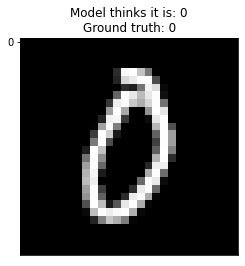

In [ ]:
# Escolha um index no intervalo [0,10'000) Cerca de 96% vai estar certo
# Alguns dificeis são : 4601, 8
index = 8
test_prediction(index,test_data_being_used,model)

## Algumas das imagens que deram errado
#### *Apenas troque esses index e vejao exemplos em que o modelo errou*

Label:  [1 0 0 0 0 0 0 0 0 0]
Prediction:  [1 0 0 0 0 0 0 0 0 0]


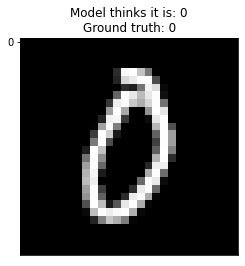

In [ ]:
# Alguns dos indexes errados:9015,8,4497,80 (usando 28k testing_data)
index_errado = 8
test_prediction(index_errado,test_data_being_used,model)

# Testaremos com novos dados gerando por desenhos no paint
### Essa função ajuda a pegar os pixels como np.array

In [ ]:
def get_pixels(filename):
	im = Image.open(filename, "r")
	pixels = list(im.getdata())
	mono_channel_pixels = [rgb[2] for rgb in pixels[0:784]]
	return np.array(mono_channel_pixels)/255.0

## Agora **edite** o aquivo *digit28x28.png* no **paint** e **rode** a celula abaixo novamente para ir atualizando a predição do modelo

Label:  made on paint
Prediction:  [0 0 0 0 1 0 0 0 0 0]


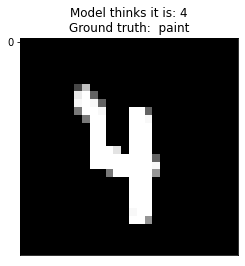

In [ ]:
test_pixels = get_pixels("digit28x28.png")
test_prediction(0,{"inputs":[test_pixels],"outputs":[[1]]},model)
